In [2]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
# %matplotlib inline     
sns.set(color_codes=True)

import random

# import scipy


In [ ]:
#logic
# start the game
# play then get reward of 4 and roll dice, if dice value is 1 or 2 then quit else continue the game
# or quit and get reward of 10

In [61]:
class DiceGameMDP:
    def __init__(self):
        self.states = ['start', 'playing', 'game over']
        self.actions = ['play', 'quit']
        self.current_state = 'start'
        self.total_reward = 0
        self.policy = {"start": "play", "playing": "play", "game over": "quit"}
        self.endState = 'game over'
        self.gamma = 0.99

        self.transition_probabilities = {
                "start": {
                    "play": {"playing": 1.0, "game over": 0.0},
                    "quit": {"playing": 0.0, "game over": 1.0}
                },
                "playing": {
                    "play": {"playing": 4/6, "game over": 2/6},
                    # Assuming the option to quit is available in 'playing' state:
                    "quit": {"playing": 0.0, "game over": 0.0}
                },
                "game over": {
                    "play": {"playing": 0.0, "game over": 1.0},
                    "quit": {"playing": 0.0, "game over": 1.0}
                }
            }
        
        self.reward_function = {
                ("start", "play", "playing"): 4,  # No reward for starting to play
                ("start", "quit", "game over"): 10,  # Reward for quitting at the start
                ("playing", "play", "playing"): 4,  # Expected reward for continuing to play and not ending the game
                ("playing", "play", "game over"): 0,  # No reward for playing and then the game ending
                ("playing", "quit", "game over"): 0,  # No reward for quitting in the middle of playing
                ("game over", "play", "game over"): 0,  # No further play possible from "game over"
                ("game over", "quit", "game over"): 0,  # No action possible from "game over"
                }


    def roll_dice(self):
        return random.randint(1, 6)

    def take_action(self,action):
        if self.current_state == 'start':
            if action == 'quit':
                self.total_reward += 10
                self.current_state = 'game over'
            elif action == 'play':
                self.total_reward += 4
                self.handle_roll()
        elif self.current_state == 'playing':
            if action == 'play':
                self.handle_roll()
        elif self.current_state == 'game over':
            print('Game is over. Please reset the game to play again.')
        return self.current_state

    def handle_roll(self):
        dice_value = self.roll_dice()
        if dice_value not in [1, 2]:
            self.total_reward += self.gamma*4
            self.current_state = 'playing'
        else:
            self.current_state = 'game over' 


    def playGame(self, action):
        self.current_state = 'start'
        self.total_reward = 0
        while self.current_state != 'game over':
            self.take_action(action)
        return self.total_reward





In [53]:
dice_game_mdp = DiceGameMDP()
# Player decides to play
dice_game_mdp.playGame('play')
print('Reward', dice_game_mdp.total_reward)

# player decides to quit
dice_game_mdp.playGame('quit')
print('Reward', dice_game_mdp.total_reward)

Current State:  start
Current State:  playing
Current State:  playing
Reward 11.92
Current State:  start
Reward 10


In [54]:
def policy_evaluation(policy, mdp,theta=0.01 ):
    # Initialize value function for each state
    V_pi = {s: 0 for s in mdp.states}
    
    def is_end(s):
        return s == mdp.endState

    # Perform policy evaluation
    while True:
        delta = 0  # This will track the maximum change in the value function

        for s in mdp.states:
            if is_end(s):
                V_pi[s] = 0
            else:
                # Calculate the action-value function Q for the current state and action according to policy
                a = policy[s]
                Q_pi = 0  # Reset the action-value function for this state-action pair
                for s_prime in mdp.states:
                    # Update Q_pi with the sum of probabilities * (specific reward + discounted value of next state)
                    Q_pi += mdp.transition_probabilities[s][a].get(s_prime, 0) * \
                            (mdp.reward_function.get((s, a, s_prime), 0) + mdp.gamma * V_pi.get(s_prime, 0))
                
                # Calculate the maximum change in the value function
                delta = max(delta, abs(Q_pi - V_pi[s]))
                
                # Update the state-value function V
                V_pi[s] = Q_pi

        # Check for convergence
        if delta < theta:
            break

    # Output the final state-value function
    for s in mdp.states:
        print(f"Value of state {s}: {V_pi[s]}")

    return V_pi



In [55]:
# Discount factor gamma
# Threshold for convergence

policy = {"start": "play", "playing": "play", "game over": "quit"}
V_pi = policy_evaluation(policy, DiceGameMDP(), theta=0.01 )
print(V_pi)




Value of state start: 11.749455383745524
Value of state playing: 7.8329702558303484
Value of state game over: 0
{'start': 11.749455383745524, 'playing': 7.8329702558303484, 'game over': 0}


In [56]:
## Straight apporach

def expected_reward_of_playing():
    """
    Calculate the expected reward for the 'Always Play' policy.
    """
    probability_of_continuing = 4/6  # Probability of rolling 3, 4, 5, or 6
    probability_of_ending = 1 - probability_of_continuing  # Probability of rolling 1 or 2
    reward_per_roll = 4

    # Expected reward is a sum of an infinite series: 4 + 4*(4/6) + 4*(4/6)^2 + 4*(4/6)^3 + ...
    expected_reward = reward_per_roll / probability_of_ending
    return expected_reward

def evaluate_policy(policy):
    """
    Evaluate the given policy.
    """
    if policy == "Always Play":
        return expected_reward_of_playing()
    elif policy == "Never Play":
        return 10  # Guaranteed reward for not playing
    else:
        raise ValueError("Unknown policy")

# Evaluate policies
reward_always_play = evaluate_policy("Always Play")
reward_never_play = evaluate_policy("Never Play")

print(f"Expected reward for 'Always Play' policy: {reward_always_play}")
print(f"Expected reward for 'Never Play' policy: {reward_never_play}")


Expected reward for 'Always Play' policy: 11.999999999999998
Expected reward for 'Never Play' policy: 10


In [62]:
## taking expectation
playgamecount = 100000
calculateexpectedreward = 0
rewards = np.array([])
for i in range(playgamecount):
    dice_game_mdp = DiceGameMDP()
    dice_game_mdp.playGame('play')
    result = dice_game_mdp.total_reward
    rewards = np.append(rewards,result)
    calculateexpectedreward += result
print('Total reward',calculateexpectedreward)
print('Expected reward',calculateexpectedreward/playgamecount)
print(rewards.shape)


Total reward 1189489.3599997573
Expected reward 11.894893599997573
(100000,)


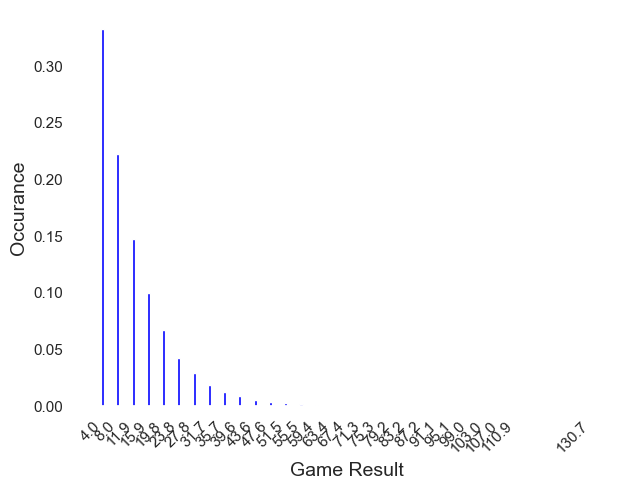

In [63]:
### Plot distirbution chart
rewards = pd.Series(rewards)
value_counts = rewards.value_counts()
plt.bar(value_counts.index, value_counts.values/rewards.shape[0], color='blue')

# Customize the plot (optional)
plt.title('Value Counts Bar Chart')
plt.xlabel('Values')
plt.ylabel('Counts')

# tenatsmoreinfo.hist(color='#D6D1C4', edgecolor='black', bins=20)
ax = plt.gca()
ax.set_facecolor('white')  # Set the background color of the plot area
plt.title('', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.xlabel('Game Result', fontsize=14)
plt.ylabel('Occurance', fontsize=14)
plt.xticks(rotation=45, ha='right') 
plt.xticks(value_counts.index)


# Show the plot
plt.show()

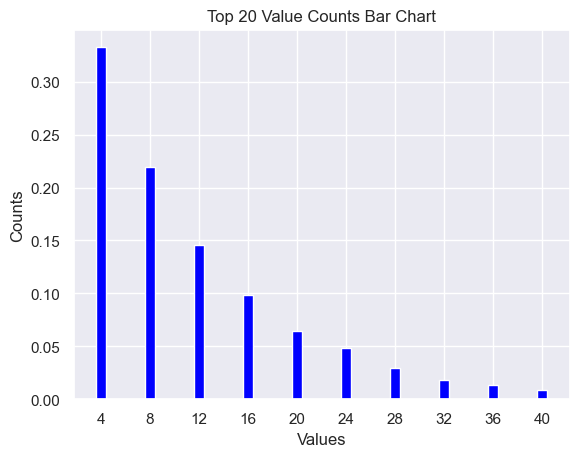

In [38]:
### Priobability distribution for top 10 values only
top_20_value_counts = value_counts.head(10)

# Create a bar chart
plt.bar(top_20_value_counts.index, top_20_value_counts.values/rewards.shape[0], color='blue')

# Customize the plot (optional)
plt.title('Top 20 Value Counts Bar Chart')
plt.xlabel('Values')
plt.ylabel('Counts')
plt.xticks(top_20_value_counts.index)

# Show the plot
plt.show()

In [55]:
class VolcanoCrossingMDP:
    def __init__(self):
        self.states = ['Tile 1', 'Tile 2', 'Tile 3', 'Tile 4', 'Tile 5', 'Game Over']
        self.volcanic_tiles = ['Tile 3']  # Example: Tile 3 is volcanic
        self.goal_tile = 'Tile 5'
        self.actions = ['Move Forward', 'Stay']

    def take_action(self, state, action):
        if state in self.volcanic_tiles or state == self.goal_tile or state == 'Game Over':
            return 'Game Over', -10  # Large penalty for volcanic tile or game over state

        if action == 'Move Forward':
            next_state = f'Tile {int(state.split()[1]) + 1}'
            if next_state == self.goal_tile:
                return next_state, 10  # Reward for reaching the goal
            else:
                return next_state, -1  # Small penalty to encourage moving forward

        elif action == 'Stay':
            return state, -1  # Small penalty for staying

# Example usage
mdp = VolcanoCrossingMDP()
current_state = 'Tile 1'
action_taken = 'Move Forward'
new_state, reward = mdp.take_action(current_state, action_taken)
print(f"New state: {new_state}, Reward: {reward}")


New state: Tile 2, Reward: -1


In [61]:
class VolcanoCrossing2DMDP:
    def __init__(self, grid):
        self.grid = grid
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.actions = ['Up', 'Down', 'Left', 'Right']
        self.goal = (2, 2)  # Assuming the goal is at (2, 2)
        self.game_over = False

    def is_valid(self, position):
        r, c = position
        return 0 <= r < self.rows and 0 <= c < self.cols

    def take_action(self, state, action):
        if self.game_over:
            return state, 0  # No reward if the game is over

        r, c = state
        new_state = (r, c)
        if action == 'Up' and self.is_valid((r - 1, c)):
            new_state = (r - 1, c)
        elif action == 'Down' and self.is_valid((r + 1, c)):
            new_state = (r + 1, c)
        elif action == 'Left' and self.is_valid((r, c - 1)):
            new_state = (r, c - 1)
        elif action == 'Right' and self.is_valid((r, c + 1)):
            new_state = (r, c + 1)

        # Check for volcanic or goal cell
        if self.grid[new_state[0]][new_state[1]] == 'V':
            self.game_over = True
            return new_state, -100  # Penalty for volcanic cell
        elif new_state == self.goal:
            return new_state, 100  # Reward for reaching the goal

        return new_state, -1  # Small penalty for each move

# Example usage
grid = [['S', '-', '-'], ['-', 'V', '-'], ['-', '-', 'G']]
mdp = VolcanoCrossing2DMDP(grid)
current_state = (0, 0)  # Starting position
action_taken = 'Right'  # Example action
new_state, reward = mdp.take_action(current_state, action_taken)
print(f"New state: {new_state}, Reward: {reward}")


New state: (0, 1), Reward: -1


In [62]:
class VolcanoCrossing2DMDP:
    def __init__(self, grid):
        self.grid = grid
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.actions = ['Up', 'Down', 'Left', 'Right']
        self.goal = (2, 2)  # Goal is at (2, 2)
        self.game_over = False

    def is_valid(self, position):
        r, c = position
        return 0 <= r < self.rows and 0 <= c < self.cols

    def take_action(self, state, action):
        if self.game_over:
            return state, 0  # No reward if the game is over

        r, c = state
        new_state = (r, c)
        if action == 'Up' and self.is_valid((r - 1, c)):
            new_state = (r - 1, c)
        elif action == 'Down' and self.is_valid((r + 1, c)):
            new_state = (r + 1, c)
        elif action == 'Left' and self.is_valid((r, c - 1)):
            new_state = (r, c - 1)
        elif action == 'Right' and self.is_valid((r, c + 1)):
            new_state = (r, c + 1)

        # Check for volcanic or goal cell
        if self.grid[new_state[0]][new_state[1]] == 'V':
            self.game_over = True
            return new_state, -100  # Penalty for volcanic cell
        elif new_state == self.goal:
            return new_state, 100  # Reward for reaching the goal

        return new_state, -1  # Small penalty for each move

# Example usage
grid = [['S', '-', '-'], ['-', 'V', '-'], ['-', '-', 'G']]
mdp = VolcanoCrossing2DMDP(grid)
current_state = (0, 0)  # Starting position

# Play the game with the given action sequence
sequence_of_actions = ['Right', 'Right', 'Down', 'Down']  # A sequence of actions

for action in sequence_of_actions:
    new_state, reward = mdp.take_action(current_state, action)
    print(f"Action: {action}, New State: {new_state}, Reward: {reward}")
    current_state = new_state

    if mdp.game_over:
        print("Game Over!")
        break

print(f"Final State: {current_state}")


Action: Right, New State: (0, 1), Reward: -1
Action: Right, New State: (0, 2), Reward: -1
Action: Down, New State: (1, 2), Reward: -1
Action: Down, New State: (2, 2), Reward: 100
Final State: (2, 2)


In [65]:
# <!-- S - - 
# - V - 
# - - G  -->
